In [168]:
%reload_ext autoreload
%autoreload 2

%matplotlib widget

import torch

torch.manual_seed(42)


In [169]:
from data.names_data_source import NamesDataSource
from data.tokenizer import Tokenizer
from learning.names_classifier.names_classifier_dataset import (
    NamesClassifierDataset,
)

tokenizer = Tokenizer()


# Initialize NamesDataset with the detected device
names_data_source = NamesDataSource.load(
    data_folder="../datasets/names",
    tokenizer=tokenizer,
    normalize_unicode=True,
)

names_dataset = NamesClassifierDataset(names_data_source, tokenizer)
sample = names_dataset[0]
print(sample)


NameSample(input=tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
  

[108, 246, 502, 286, 3668, 273, 690, 193, 226, 701, 990, 94, 138, 74, 9340, 100, 293, 71]


<BarContainer object of 18 artists>

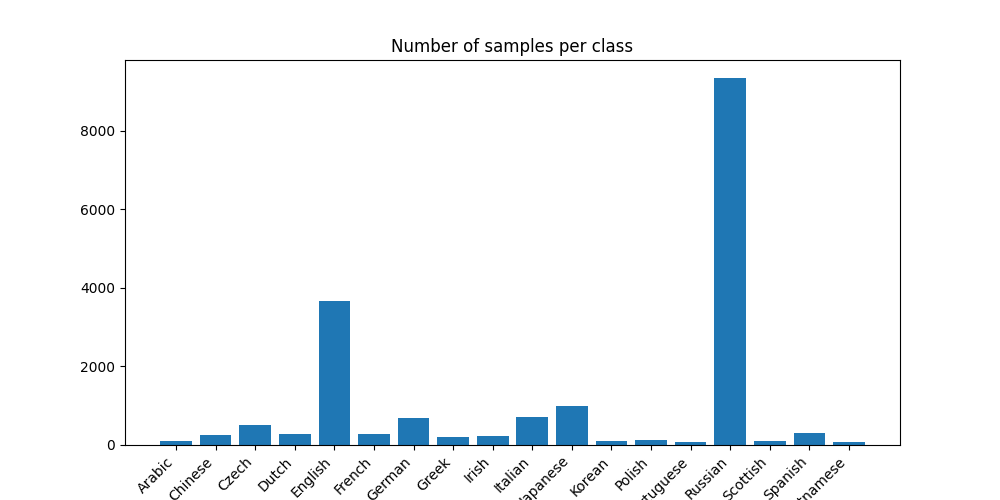

In [170]:
import matplotlib.pyplot as plt

samples_count_per_class = [
    len(names_data_source.country_idx_to_names[i])
    for i in range(len(names_data_source.countries))
]
print(samples_count_per_class)

_, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Number of samples per class")
ax.set_xticks(range(len(samples_count_per_class)))
ax.set_xticklabels(names_data_source.countries, rotation=45, ha="right")
ax.bar(range(len(samples_count_per_class)), samples_count_per_class)


In [171]:
train_dataset, test_dataset = torch.utils.data.random_split(names_dataset, [0.85, 0.15])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 15295
Test dataset size: 2698


In [172]:
train_sampler_weights = [
    1 / samples_count_per_class[int(sample.label.item())] for sample in train_dataset
]
print(train_sampler_weights[10000:10010])

criterion_weights = torch.tensor(samples_count_per_class) ** 0.5
criterion_weights /= criterion_weights.sum()
print(criterion_weights)


[0.0014492753623188406, 0.00010706638115631691, 0.0002726281352235551, 0.00010706638115631691, 0.00010706638115631691, 0.0002726281352235551, 0.00010706638115631691, 0.00010706638115631691, 0.00010706638115631691, 0.00010706638115631691]
tensor([0.0249, 0.0375, 0.0536, 0.0405, 0.1449, 0.0395, 0.0629, 0.0332, 0.0360,
        0.0634, 0.0753, 0.0232, 0.0281, 0.0206, 0.2313, 0.0239, 0.0410, 0.0202])


In [173]:
import math
import time
import torch
from learning.names_classifier.model import (
    Batch,
    ParallelBatchLearner,
    SequentialBatchLearner,
    NamesClassifierLSTM,
)
from learning.metrics import (
    ConfusionMatrixMetric,
)

from torch.utils.data import WeightedRandomSampler, DataLoader
from torch import nn

BATCH_SIZE = 64
LEARNING_RATE = 5e-4
HIDDEN_SIZE = 64
NUM_EPOCHS = 500
PATIENCE = 25

model = NamesClassifierLSTM(
    input_size=tokenizer.vocab_size,
    hidden_size=HIDDEN_SIZE,
    output_size=names_data_source.num_classes,
)
print(model)
criterion = nn.CrossEntropyLoss(reduction="sum")
print(criterion)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print(optimizer)

learner = ParallelBatchLearner(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
)
print(learner)


train_sampler = WeightedRandomSampler(
    weights=train_sampler_weights,
    num_samples=len(train_dataset),
    replacement=True,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=train_sampler,
    batch_size=BATCH_SIZE,
    collate_fn=Batch.from_samples,
)

eval_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=Batch.from_samples,
)

train_confusion_matrix_metric = ConfusionMatrixMetric(
    classes=names_data_source.countries
)

eval_confusion_matrix_metric = ConfusionMatrixMetric(
    classes=names_data_source.countries
)

first_confusion_matrix_metric = ConfusionMatrixMetric(
    classes=names_data_source.countries
)
first_epoch_loss = learner.final_eval(
    dataloader=train_dataloader, metrics=[first_confusion_matrix_metric]
)
print(f"Expecting initial loss around {math.log(names_data_source.num_classes)}")
print(first_epoch_loss)

NamesClassifierLSTM(
  (lstm): LSTM(58, 64, bidirectional=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
)
CrossEntropyLoss()
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0.01
)
Expecting initial loss around 2.8903717578961645
2.8921407449553316


In [ ]:
print(
    "Starting training...\n"
    f"Expecting initial loss around {math.log(names_data_source.num_classes)}"
)
start_time = time.time()
train_losses, eval_losses = learner.fit(
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    train_metrics=[train_confusion_matrix_metric],
    eval_metrics=[eval_confusion_matrix_metric],
)
elapsed_time = time.time() - start_time
print(f"Training completed. Elapsed time: {elapsed_time:.2f}s")


Starting training...
Expecting initial loss around 2.8903717578961645
0/500 -- 1.71s 	Train loss 	2.6959 	Eval loss 	2.3035 	<<
1/500 -- 1.69s 	Train loss 	2.0512 	Eval loss 	1.9678 	<<
2/500 -- 1.72s 	Train loss 	1.7481 	Eval loss 	1.8348 	<<
3/500 -- 1.75s 	Train loss 	1.5604 	Eval loss 	1.6444 	<<
4/500 -- 1.62s 	Train loss 	1.4448 	Eval loss 	1.5103 	<<
5/500 -- 1.62s 	Train loss 	1.3415 	Eval loss 	1.4773 	<<
6/500 -- 1.66s 	Train loss 	1.2807 	Eval loss 	1.4044 	<<
7/500 -- 1.69s 	Train loss 	1.2122 	Eval loss 	1.3618 	<<
8/500 -- 1.63s 	Train loss 	1.1741 	Eval loss 	1.3299 	<<
9/500 -- 1.61s 	Train loss 	1.1269 	Eval loss 	1.3363 	
10/500 -- 1.62s 	Train loss 	1.0892 	Eval loss 	1.3314 	
11/500 -- 1.65s 	Train loss 	1.0426 	Eval loss 	1.2982 	<<
12/500 -- 1.66s 	Train loss 	1.0074 	Eval loss 	1.3102 	
13/500 -- 1.61s 	Train loss 	0.9720 	Eval loss 	1.1876 	<<
14/500 -- 1.62s 	Train loss 	0.9336 	Eval loss 	1.2678 	
15/500 -- 1.61s 	Train loss 	0.9277 	Eval loss 	1.2090 	
16/500

## LOG

Manual Seed = 42

### Things to try

- Consider also adding feature on frequency in the dataset?
    - frequency_in_country_X -- relative frequency
    - frequency_across_all_countries -- absolute frequency
- Normalize names?
- Multi-label classification?
- Try Embedding!

### Experiment 1

First Experiment:
- model = RNN
- BATCH_SIZE = 64
- LEARNING_RATE = 0.001
- HIDDEN_SIZE = 64
- NUM_EPOCHS = 50
- PATIENCE = 5

Result
- 29/50 -- 3.66s 	Train loss 	0.4853 	Eval loss 	0.6321
- Recall for Portugese, Scottish, Vietnamese are really low

### Experiment 2

Changes:
- BATCH_SIZE = 128

Result
- 45/50 -- 3.73s 	Train loss 	0.4493 	Eval loss 	0.6522
- Korean recall for eval is much worse
- Vietnamese recall is better

### Experiment 3

Changes:
- BATCH_SIZE = 32

Result
- 27/50 -- 3.71s 	Train loss 	0.4340 	Eval loss 	0.6441
- Still bad at Scottish, but better than before

### Experiment 4

Changes
- HIDDEN_SIZE = 128

Result
- 21/50 -- 4.22s 	Train loss 	0.3574 	Eval loss 	0.6969
- Training completed. Elapsed time: 93.07s
- Bigger model fits better. Eval result is stll horrible.

### Experiment 5

Changes:
- model = BiLSTM

Result
- 18/50 -- 64.10s 	Train loss 	0.3235 	Eval loss 	0.6190
- Training completed. Elapsed time: 1242.25s
- LSTM is really slow. Slightly better result.

### Experiment 6

Changes:
- model = BiLSTM, ParallelBatchLearner

Result
- 21/50 -- 8.67s 	Train loss 	0.2822 	Eval loss 	0.6491
- Training completed. Elapsed time: 187.26s
- Good speed up with decent metrics

### Experiment 7

Changes:
- BATCH_SIZE = 16

Result
- 15/50 -- 9.96s 	Train loss 	0.3147 	Eval loss 	0.6260
- Training completed. Elapsed time: 158.88s
- It seems smaller batch size helps with learning from imbalance dataset

### Experiment 8

Changes:
- Use WeightedRandomSampler

Result
- 23/50 -- 9.91s 	Train loss 	0.2145 	Eval loss 	1.0249
- Training completed. Elapsed time: 239.11s
- The model does _way_ worse on the eval set.
- But it manages to have better overall F1 and ConfusionMatrix

### Experiment 8

Changes:
- BATCH_SIZE = 32

Result
- 17/50 -- 7.93s 	Train loss 	0.3091 	Eval loss 	0.9786
- Training completed. Elapsed time: 144.24s

### Experiment 9

Changes:
- BATCH_SIZE = 64
- Use log criterion weights

Result
- 37/50 -- 5.55s 	Train loss 	0.2299 	Eval loss 	0.8690
- Training completed. Elapsed time: 211.39s
- Probably the best run yet! The confusion matrix is beautiful!

### Observation 10

- Many names belong to the same category!
- Consider also adding feature on frequency in the dataset?
    - frequency_in_country_X -- relative frequency
    - frequency_across_all_countries -- absolute frequency
- Normalize names?
- Multi-label classification?

### Experiment 11

Changes:
- Fix padded tokens contributing to the learning process
- Remove duplicated names per country (so many duplicated Arabic names)
- BATCH_SIZE = 64
- LEARNING_RATE = 1e-3
- HIDDEN_SIZE = 128
- NUM_EPOCHS = 500
- PATIENCE = 10

Result:
- 33/500 -- 4.96s 	Train loss 	0.2851 	Eval loss 	0.5603
- Training completed. Elapsed time: 166.94s
- Lowest validation loss so far!

### Experiment 12

Changes:
- Reduce the LSTM layer to 1

Result:
- 46/500 -- 2.57s 	Train loss 	0.3494 	Eval loss 	0.5420 	
- Training completed. Elapsed time: 119.74s
- The model were too complex for the training data. Eval loss could get down to 0.4 if we stopped earlier.

### Experiment 13

Changes:
- Dropout to 0.2
- AdamW

Result:
- 45/500 -- 2.45s 	Train loss 	0.2647 	Eval loss 	0.5277 	
- Training completed. Elapsed time: 113.98s
- Slightly better result

### Experiment 14

Changes:
- Dropout to 0.1
- HIDDEN_SIZE = 64
- LEARNING_RATE = 5e-4

Result:
- 98/500 -- 1.65s 	Train loss 	0.3773 	Eval loss 	0.5055 	
- Training completed. Elapsed time: 163.48s
- Continue the trend of lower eval loss

Text(0.5, 1.0, 'F1 Score')

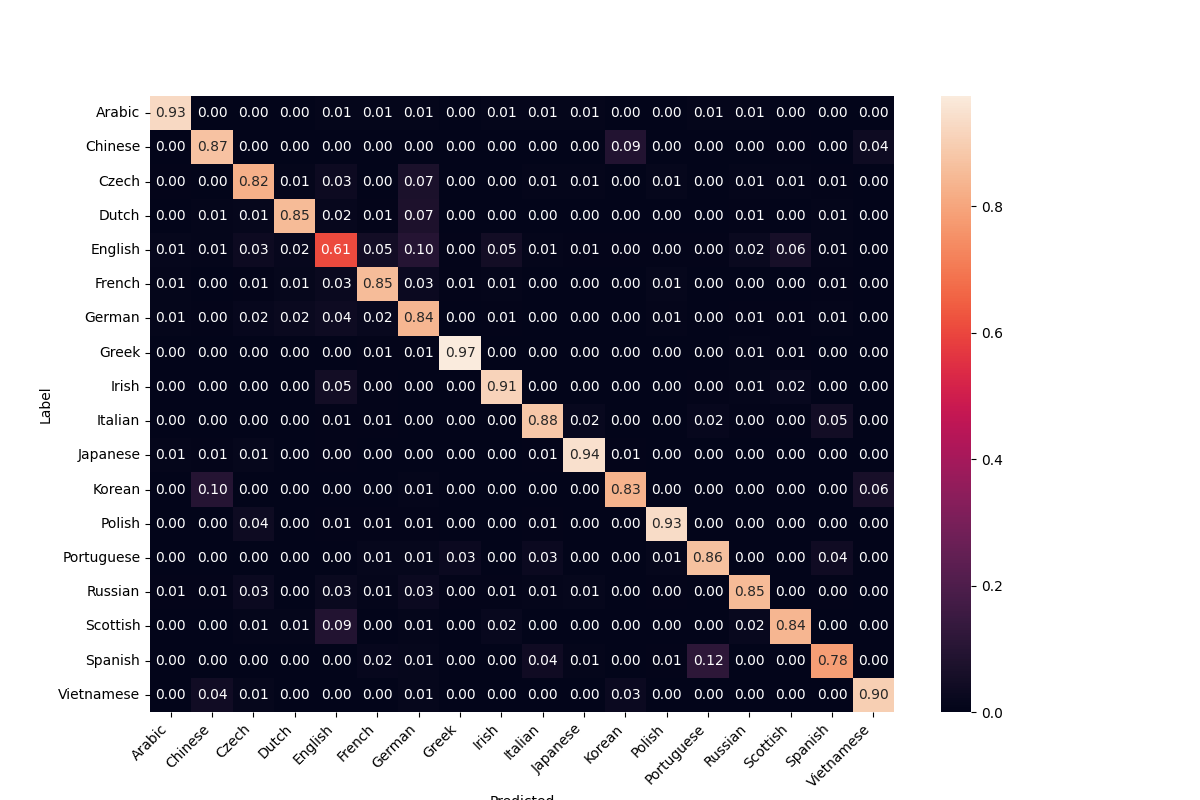

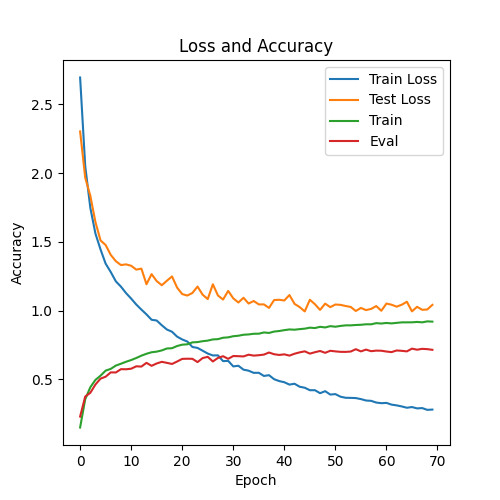

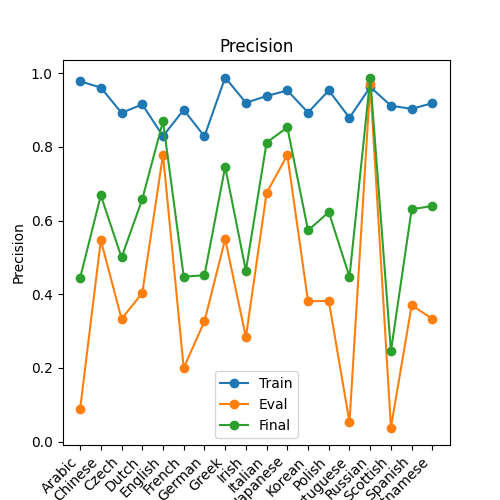

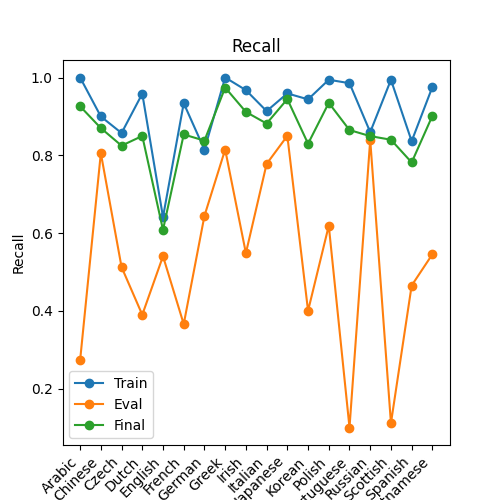

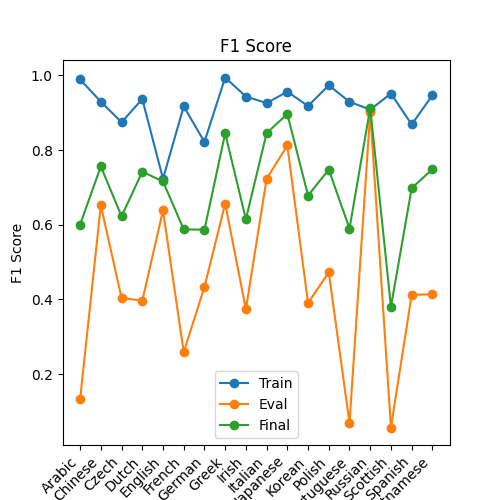

In [165]:
import matplotlib.pyplot as plt


full_dataloader = DataLoader(
    dataset=names_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=Batch.from_samples,
)
full_confusion_matrix_metric = ConfusionMatrixMetric(
    classes=names_data_source.countries
)
final_loss = learner.final_eval(
    dataloader=full_dataloader, metrics=[full_confusion_matrix_metric]
)

_, ax = plt.subplots(figsize=(12, 8))
full_confusion_matrix_metric.plot_confusion_matrix(ax, normalize=True)

_, ax = plt.subplots(figsize=(5, 5))
ax.plot(train_losses, label="Train Loss")
ax.plot(eval_losses, label="Test Loss")
train_confusion_matrix_metric.plot_accuracies(ax, "Train")
eval_confusion_matrix_metric.plot_accuracies(ax, "Eval")
ax.set_title("Loss and Accuracy")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_precisions(ax, "Train")
eval_confusion_matrix_metric.plot_class_precisions(ax, "Eval")
full_confusion_matrix_metric.plot_class_precisions(ax, "Final")
ax.set_title("Precision")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_recalls(ax, "Train")
eval_confusion_matrix_metric.plot_class_recalls(ax, "Eval")
full_confusion_matrix_metric.plot_class_recalls(ax, "Final")
ax.set_title("Recall")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_f1_scores(ax, "Train")
eval_confusion_matrix_metric.plot_class_f1_scores(ax, "Eval")
full_confusion_matrix_metric.plot_class_f1_scores(ax, "Final")
ax.set_title("F1 Score")


Linear(in_features=128, out_features=18, bias=True)
tensor([[ 0.9291,  0.6841,  0.1610,  ..., -0.4053, -0.0146,  0.1769],
        [ 0.0281, -0.2507, -0.2100,  ..., -0.2380, -0.1474, -0.1623],
        [ 0.0608,  0.6786,  0.9099,  ..., -0.2666,  0.1421, -0.3286],
        ...,
        [ 0.5750,  0.8024, -0.2173,  ...,  0.6832,  0.2195, -0.8129],
        [-0.0465, -0.7165,  0.3826,  ...,  0.3194,  0.0667, -0.0390],
        [-0.7667,  0.2927,  0.8039,  ..., -0.0498, -0.9373, -0.2651]])


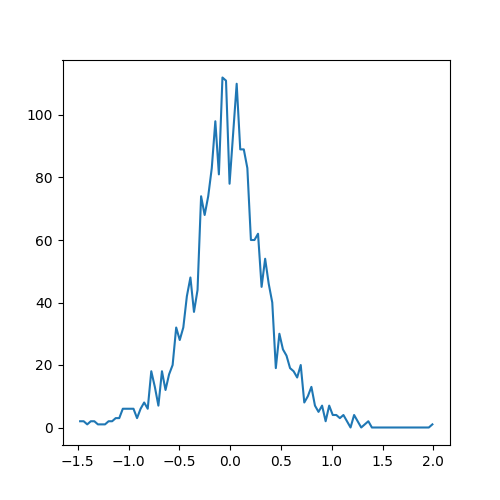

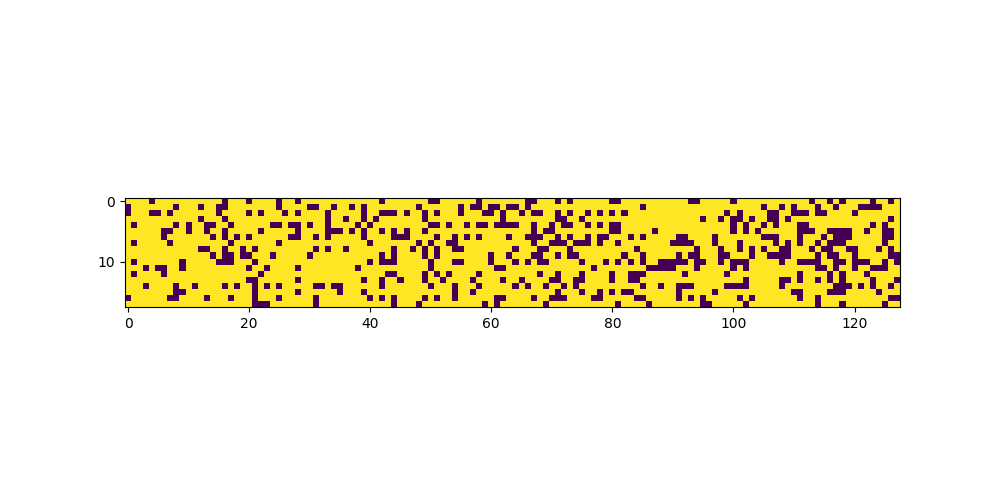

In [166]:
print(model.fc)
print(model.fc.weight.data)

hist, bin_edges = torch.histogram(model.fc.weight.data)
f, ax = plt.subplots(figsize=(5, 5))
ax.plot(bin_edges[:-1], hist)

plt.figure(figsize=(10, 5))
plt.imshow(model.fc.weight.abs() > 0.1)


In [167]:
likelihoods, indices = learner.predict_topk(
    tokenizer.to_one_hot("Hai", batch_dim=1), k=3
)
for likelihood, country_idx in zip(likelihoods, indices):
    print(f"{likelihood:.2f} {names_data_source.countries[country_idx]}")

print(f"Total likelihood: {likelihoods.sum().item():.2f}")


0.74 Vietnamese
0.25 Chinese
0.01 Korean
Total likelihood: 1.00
